# Проект по А/B-тестированию

## Цель проекта
Провести оценку результатов A/B-теста

## Входные данные
1. Техническое задание
2. Таблицы с данными:  
ab_project_marketing_events.csv  
final_ab_new_users.csv  
final_ab_events.csv  
final_ab_participants.csv

## Содержание
<h3>Шаг 1.<a href='#session1'>Исследование данных</a></h3>
<h4>Шаг 1.1<a href='#session1.1'>Преобразование типов</a></h4>
<h4>Шаг 1.2<a href='#session1.2'>Работа с пропусками и дубликатами</a></h4>
<h3>Шаг 2.<a href='#session2'>Исследовательский анализ данных</a></h3>
<h4>Шаг 2.1<a href='#session2.1'>Конверсия в воронке на разных этапах</a></h4>
<h4>Шаг 2.2<a href='#session2.2'>Обладают ли выборки одинаковыми распределениями количества событий на пользователя</a></h4>
<h4>Шаг 2.3<a href='#session2.3'>Присутствуют ли в выборках одни и те же пользователи</a></h4>
<h4>Шаг 2.4<a href='#session2.4'>Как число событий распределено по дням</a></h4>
<h4>Шаг 2.5<a href='#session2.5'>Нюансы данных, которые нужно учесть</a></h4>
<h3>Шаг 3.<a href='#session3'>Оценка результатов A/B-тестирования</a></h3>
<h4>Шаг 3.1<a href='#session3.1'>Что можно сказать про результаты A/B-тестирования</a></h4>
<h4>Шаг 3.2<a href='#session3.2'>Проверка статистической разници долей z-критерием</a></h4>
<h3>Шаг 4.<a href='#session4'>Вывод</a></h3>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math as mth
import warnings
warnings.filterwarnings("ignore")

<a id='session1'></a>
### Исследование данных

In [2]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [6]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


<a id='session1.1'></a>
#### Преоразование типов

In [7]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [8]:
users['first_date'] = pd.to_datetime(users['first_date'])

In [9]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

#### Вывод
Преобразовали в дату нужные поля

<a id='session1.2'></a>
#### Работа с пропусками и дубликатами

In [10]:
print(f'Дубликатов в таблтце marketing_events {marketing_events.duplicated().sum()}')
print(f'Дубликатов в таблтце participants {participants.duplicated().sum()}')
print(f'Дубликатов в таблтце events {events.duplicated().sum()}')
print(f'Дубликатов в таблтце users {users.duplicated().sum()}')

Дубликатов в таблтце marketing_events 0
Дубликатов в таблтце participants 0
Дубликатов в таблтце events 0
Дубликатов в таблтце users 0


#### Вывод
Полных дублей нет.  
Пропуски в столбце **details** таблицы **events** обоснованы тем, что в этом столбце указана стоимость покупки, но покупка (**purchase**)
это только однин тип событый, для других стоимости быть не может

<a id='session2'></a>
### Исследовательский анализ данных

<a id='session2.1'></a>
#### Конверсия в воронке на разных этапах

In [11]:
# Посчитаем количество уникальных пользователей
users_count = events.groupby('event_name').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id',ascending=False)

In [12]:
# Считаем конферсию
users_count['lag'] = users_count['user_id'].shift(1)
users_count['conversion'] = round(users_count['user_id']/users_count['lag'],2)

In [13]:
users_count.style.format({'conversion':'{:.0%}'})

,event_name,user_id,lag,conversion
0,login,58697,nan,nan%
2,product_page,38929,58697,66%
3,purchase,19569,38929,50%
1,product_cart,19284,19569,99%


#### Вывод
Конверсия 66% на шаге **product_page** означает, что каждый 3-ий пользователь не заходит на страницу с товаром, это странно, возмжно
эти пользвоатели заходят с однотипных устройств (например смартфоны) и на них едет верстка...

<a id='session2.2'></a>
#### Обладают ли выборки одинаковыми распределениями количества событий на пользователя

In [14]:
# Сделаем срез для теста recommender_system_test
participants_recomend_syst = participants[participants['ab_test']=='recommender_system_test']

In [15]:
# Соединим нужные таблицы
events_participants = events.merge(participants_recomend_syst, on='user_id')

In [16]:
# Выделим две отдельные таблицы для тестовых групп
events_participants_a = events_participants[events_participants['group']=='A']
events_participants_b = events_participants[events_participants['group']=='B']

In [17]:
# Распределение событий на пользователя для группы А
a_group_mean_events = events_participants_a.groupby('user_id')['event_name'].count().reset_index()
# Распределение событий на пользователя для группы В
b_group_mean_events = events_participants_b.groupby('user_id')['event_name'].count().reset_index()

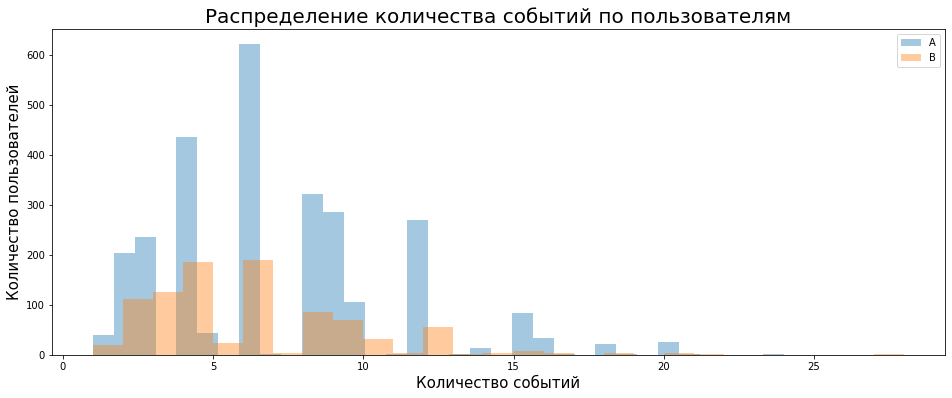

In [18]:
plt.figure(figsize=(16,6))
sns.distplot(a_group_mean_events['event_name'],kde=False)
sns.distplot(b_group_mean_events['event_name'],kde=False)
plt.legend(['A','B'])
plt.xlabel('Количество событий',fontsize=15)
plt.ylabel('Количество пользователей',fontsize=15)
plt.title('Распределение количества событий по пользователям',fontsize=20)
plt.show()

#### Вывод
Распределение событий на пользвоателя для теста **recommender_system_test** схожи для А и В.  
В контрольной группе больше самих пользователей

<a id='session2.3'></a>
#### Присутствуют ли в выборках одни и те же пользователи

In [19]:
participants_a = participants_recomend_syst[participants_recomend_syst['group']=='A']
participants_b = participants_recomend_syst[participants_recomend_syst['group']=='B']

In [20]:
inner_participants = participants_a.merge(participants_b, on='user_id')
inner_participants

,user_id,group_x,ab_test_x,group_y,ab_test_y


#### Вывод
В выборках нет одних и тех же пользователи

In [21]:
rs_test = participants[participants['ab_test']=='recommender_system_test']
eu_test = participants[participants['ab_test']=='interface_eu_test']

all_test = rs_test.merge(eu_test,on='user_id')
all_test_B = all_test[all_test['group_y']=='B']

In [22]:
print('Сколько пользвоателей побывало в двух тестах -', all_test['user_id'].nunique())

Сколько пользвоателей побывало в двух тестах - 1602


<a id='session2.4'></a>
#### Как число событий распределено по дням

In [23]:
events_participants_rs = events.merge(participants_recomend_syst, on='user_id')
# Уберем тех, кто участвовал в тесте interface_eu_test в группе В
events_participants_rs = events_participants_rs.query('user_id not in @all_test_B.user_id')

In [24]:
A = events_participants_rs[events_participants_rs['group']=='A']
B = events_participants_rs[events_participants_rs['group']=='B']


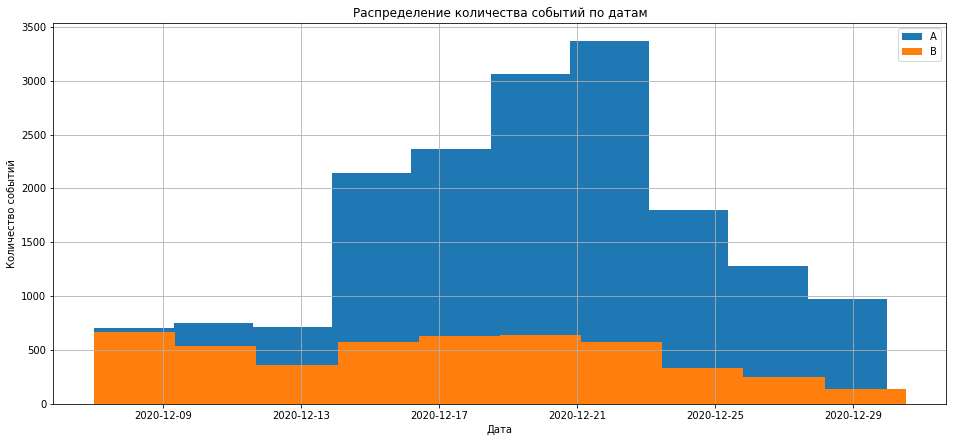

In [25]:
plt.figure(figsize=(16,7))
A['event_dt'].hist()
B['event_dt'].hist()
plt.legend(['A','B'])
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий по датам');

#### Вывод
В середине теста было наибольшее количество событий, это из-за приближения праздников НГ, все покупают подарки

<a id='session2.5'></a>
#### Нюансы данных, которые нужно учесть

In [26]:
# Когда произошло последнее событие теста
events_participants_rs['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

In [27]:
# Когда была остановка набора пользователей для теста.
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [28]:
# Сколько всего пользвоателей из UE
eu_users = users[users['region']=='EU']['user_id'].nunique()

In [29]:
event_par_users = events_participants_rs.merge(users,on='user_id',how='left')
# Сколько пользователей из EU участвует в тесте
eu_users_test = event_par_users[event_par_users['region']=='EU']['user_id'].nunique()

In [30]:
print('Доля новых пользвоателей EU, участвовавших в тесте {:.2%}'.format(eu_users_test/eu_users))

Доля новых пользвоателей EU, участвовавших в тесте 6.59%


#### Вывод
Нужно учесть:
1. Наличие выбросов в данных (количество сбытий у пользователей)
2. Программа для разделения трафика работает корректно (поровну делит выборки). У нас деление неравномерное.
3. Корректно ли система аналитики собирает данные (проверка через АА тест)
4. Полследнее событие теста recommender_system_test произошло 2020-12-30, скорее вего это дата остановки, ведь вероятность того, что ни одного события после этой даты не произошло ничтожно мала. По ТЗ тест должен быть остановлен 2021-01-04.
5. Остановка набора пользователей была 2020-12-23, по ТЗ 2020-12-21
6. 7.52% новых пользователей из EU, по ТЗ 15%

<a id='session3'></a>
### Оценка результатов A/B-тестирования

<a id='session3.1'></a>
#### Что можно сказать про результаты A/B-тестирования

In [31]:
# Найдем кол-во просмотров карточек товаров каждого пользователя группы А
product_page_A = events_participants_rs[(events_participants_rs['group']=='A')&\
                                        (events_participants_rs['event_name']=='product_page')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})
# Найдем кол-во просмотров карточек товаров каждого пользователя группы В
product_page_B = events_participants_rs[(events_participants_rs['group']=='B')&\
                                        (events_participants_rs['event_name']=='product_page')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})


# Найдем кол-во просмотров корзины каждого пользователя группы А
product_cart_A = events_participants_rs[(events_participants_rs['group']=='A')&\
                                        (events_participants_rs['event_name']=='product_cart')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})
# Найдем кол-во просмотров корзины каждого пользователя группы В
product_cart_B = events_participants_rs[(events_participants_rs['group']=='B')&\
                                        (events_participants_rs['event_name']=='product_cart')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})


# Найдем кол-во покупок каждого пользователя группы А
purchase_A = events_participants_rs[(events_participants_rs['group']=='A')&\
                                        (events_participants_rs['event_name']=='purchase')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})
# Найдем кол-во покупок каждого пользователя группы В
purchase_B = events_participants_rs[(events_participants_rs['group']=='B')&\
                                        (events_participants_rs['event_name']=='purchase')].groupby('user_id', as_index=False).\
agg({'event_name' :'count'})


In [32]:
# Найдем количестов залогинившихся пользвоателей в группах
login_A = events_participants_rs[events_participants_rs['group']=='A']['user_id'].count()
login_B = events_participants_rs[events_participants_rs['group']=='B']['user_id'].count()

In [33]:
prod_page_A_conversion = product_page_A['event_name'].sum() / login_A 
prod_page_B_conversion = product_page_B['event_name'].sum() / login_B

prod_cart_A_conversion = product_cart_A['event_name'].sum() / login_A
prod_cart_B_conversion = product_cart_B['event_name'].sum() / login_B 

purchase_A_conversion = purchase_A['event_name'].sum() / login_A
purchase_B_conversion = purchase_B['event_name'].sum() / login_B 

In [34]:
print('Относительная конверсия В к А на шаге product_page {0:.2%}'.format(prod_page_B_conversion / prod_page_A_conversion-1))
print('Относительная конверсия В к А на шаге product_cart {0:.2%}'.format(prod_cart_B_conversion / prod_cart_A_conversion-1))
print('Относительная конверсия В к А на шаге purchase {0:.2%}'.format(purchase_B_conversion / purchase_A_conversion-1))

Относительная конверсия В к А на шаге product_page -9.69%
Относительная конверсия В к А на шаге product_cart -3.69%
Относительная конверсия В к А на шаге purchase -10.16%


In [35]:
print('Конверсия шагов группы А:')
print('Конверсия просмотра карточек продуктов', product_page_A['event_name'].sum()/login_A )
print('Конверсия просмотра корзины', product_cart_A['event_name'].sum() / login_A )
print('Конверсия покупки' , purchase_A['event_name'].sum() / login_A)
print('')
print('Конверсия шагов группы В:')
print('Конверсия просмотра карточек продуктов', product_page_B['event_name'].sum() / login_B)
print('Конверсия просмотра корзины', product_cart_B['event_name'].sum() / login_B)
print('Конверсия покупки', purchase_B['event_name'].sum() / login_B)

Конверсия шагов группы А:
Конверсия просмотра карточек продуктов 0.2859641961630416
Конверсия просмотра корзины 0.13318560849029099
Конверсия покупки 0.13755904134351857

Конверсия шагов группы В:
Конверсия просмотра карточек продуктов 0.25825697847858514
Конверсия просмотра корзины 0.128276155976987
Конверсия покупки 0.12358832303430642


In [36]:
# Првоерка статистической разницы выборок
print("Стат. значимость на шаге карточки товара {0:.30f}".format(stats.mannwhitneyu(product_page_A['event_name'], product_page_B['event_name'])[1]))
print("Стат. значимость на шаге корзины {0:.30f}".format(stats.mannwhitneyu(product_cart_A['event_name'], product_cart_B['event_name'])[1]))
print("Стат. значимость на шаг епокупки {0:.30f}".format(stats.mannwhitneyu(purchase_A['event_name'], purchase_B['event_name'])[1]))

Стат. значимость на шаге карточки товара 0.000000000000000929743778499055
Стат. значимость на шаге корзины 0.000000058874423762577781053665
Стат. значимость на шаг епокупки 0.000000028893387083622126977112


#### H0 гепотиза - между выборками НЕТ статистически значимая разница
#### Н1 гепотиза - между выборками ЕСТЬ статистически значимая разница

#### Вывод
Пользователи из выборки **В** показали худшую конверсию воронки на всех шагах, разница статистически значима. Мы отвергаем нулевую гепотезу.  
Результаты отрицательные, но многие требования ТЗ не выполнены, поэтому результаты нельзя назвать достоверными

<a id='session3.2'></a>
#### Проверка статистической разници долей z-критерием

In [37]:
# Найдем количество пользователей в каждой группе
print(events_participants_rs[events_participants_rs['group']=='A']['user_id'].nunique())
print(events_participants_rs[events_participants_rs['group']=='B']['user_id'].nunique())

2422
822


In [38]:
# Найдем количество событий purchase по группам
print(events_participants_rs[(events_participants_rs['group']=='A')&(events_participants_rs['event_name']=='purchase')]['user_id'].nunique())
print(events_participants_rs[(events_participants_rs['group']=='B')&(events_participants_rs['event_name']=='purchase')]['user_id'].nunique())

773
226


In [39]:
# Найдем количество событий product_cart по группам
print(events_participants_rs[(events_participants_rs['group']=='A')&(events_participants_rs['event_name']=='product_cart')]['user_id'].nunique())
print(events_participants_rs[(events_participants_rs['group']=='B')&(events_participants_rs['event_name']=='product_cart')]['user_id'].nunique())

728
225


In [40]:
# Найдем количество событий product_page по группам
print(events_participants_rs[(events_participants_rs['group']=='A')&(events_participants_rs['event_name']=='product_page')]['user_id'].nunique())
print(events_participants_rs[(events_participants_rs['group']=='B')&(events_participants_rs['event_name']=='product_page')]['user_id'].nunique())

1571
459


In [41]:
count_users = np.array([2422,822])
list_count_events_A = [773,728,1571]
list_count_events_B = [226,225,459]
name_stage = ['purchase','product_count','product_page']

In [44]:
for i,j,k in zip(range(len(list_count_events_A)),range(len(list_count_events_B)),name_stage):
    p1 = list_count_events_A[i]/count_users[0]
    p2 = list_count_events_B[j]/count_users[1]

    p_combined = (list_count_events_A[i]+list_count_events_B[j]) / (count_users[0]+count_users[1])
    difference = p1-p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/count_users[0] + 1/count_users[1]))
    distr = stats.norm(0, 1)
    
    alpha = 0.05/3 # 3 - число сравнений, считаем поправку Бонферрони
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Для шага', k)
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

Для шага purchase
p-значение:  0.01764968717521609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для шага product_count
p-значение:  0.14412076974264498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Для шага product_page
p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Вывод
Разница долей статистически значима для шагов **purchase и product_page**, а для шага **product_cart** нет

<a id='session4'></a>
### Вывод

1. Активность пользователей сильно возрастает за 2 недели до НГ
2. При сборе данных не были учтены все требования ТЗ:
    - Доля пользвоателей EU менее 15%  
    - Набор новых пользвателей закончен на 2 дня позже  
    - Тест остановлен на 5 дней позже
3. Разбиение на группы **А В** прошло не равно 
4. Хоть группа **В** показала худшую конверсию и результат статистически значим, тест нельзя считать удачным из-за неудовлетворения многих требований ТЗ 